# Biomass Mapping

In [1]:
#Importing a few necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Now I will import the csv file containing data for each crop for Agro-Climatic Potential Yield as potential_yield.


In [2]:
potential_yield = pd.read_csv("./dataset/potentialyield.csv")
cell_c2= potential_yield.iloc[2,14]
harvested_area = pd.read_csv("./dataset/harvest_data_actual.csv")

In [3]:
print(cell_c2)

 https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/CRUTS32/Hist/6190H/barl200a_yld.tif


Importing shapefiles for Indian states (Shapefiles taken from GADM)

In [4]:
import geopandas as gpd

# Specify the path to the shapefile (.shp) file
shapefile_path = "./shapefiles_india/gadm41_IND_shp/gadm41_IND_1.shp"

shapefile_iceland = "./shapefiles_india/gadm41_ISL_shp/gadm41_ISL_0.shp"
iceland = gpd.read_file(shapefile_iceland)

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Print the first few rows of the GeoDataFrame
print(gdf.head())


     GID_1 GID_0 COUNTRY               NAME_1   
0  IND.1_1   IND   India  Andaman and Nicobar  \
1  IND.2_1   IND   India       Andhra Pradesh   
2  IND.3_1   IND   India    Arunachal Pradesh   
3  Z07.3_1   Z07   India    Arunachal Pradesh   
4  IND.4_1   IND   India                Assam   

                          VARNAME_1 NL_NAME_1          TYPE_1   
0  Andaman & Nicobar Islands|Andama        NA  Union Territor  \
1                                NA        NA           State   
2  Agence de la Frontière du Nord-E        NA           State   
3  Agence de la Frontière du Nord-E        NA           State   
4                                NA        NA           State   

         ENGTYPE_1 CC_1 HASC_1  ISO_1   
0  Union Territory   NA  IN.AN     NA  \
1            State   NA  IN.AP  IN-AP   
2            State   NA  IN.AR  IN-AR   
3            State   NA  IN.AR     NA   
4            State   NA  IN.AS  IN-AS   

                                            geometry  
0  MULTIPOLY

Dsiplaying the shapefile for the states of Punjab, India and Kerala,India in order to perform the mapping on a small scale first before moving to the world map.

<Axes: title={'center': 'KERALA'}, xlabel='Longitude', ylabel='Latitude'>

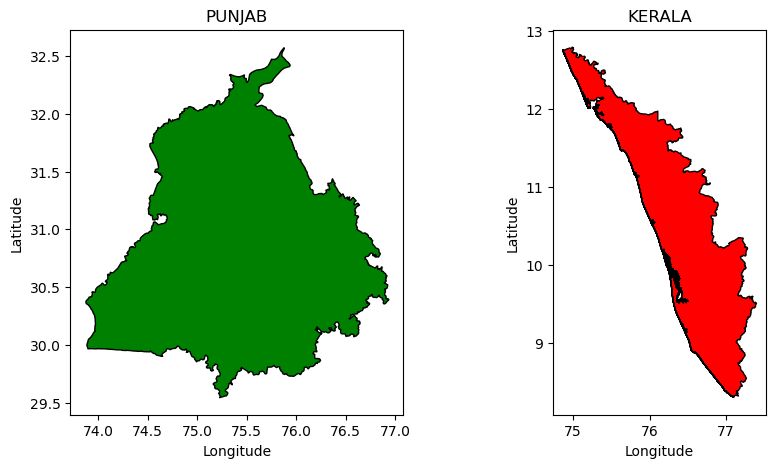

In [5]:
#assigning the variables Punjab and Kerala to their respective geodataframe
punjab = gdf[gdf['NAME_1']=='Punjab']
kerala = gdf[gdf['NAME_1']=='Kerala']
rajasthan = gdf[gdf['NAME_1']=='Rajasthan']
himachal_pradesh = gdf[gdf['NAME_1']=='Himachal Pradesh']
mizoram = gdf[gdf['NAME_1']=='Mizoram']
fig,axs= plt.subplots(1,2,figsize=(10,5))
axs[0].set_title('PUNJAB')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[1].set_title('KERALA')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
punjab.plot(ax=axs[0], color = 'green', edgecolor='black')
kerala.plot(ax=axs[1], color = 'red', edgecolor='black')

# Biomass Potential from Agricultural Residues for Actual Yield (2000 and 2010)

So for calculating the biomass potential of residues we have the production values data from GAEZ v4 for the years 2000 and 2010 which we will be using. The data in these rasters gives us the production of the particular crop in 1000 tonnes or 1 mln GK\\$. The other unit present in the data is mln GK\\$ which is used by FAO for crop groups like Fodder Crops, Pulses, Vegetables etc.

The documentation of the GAEZ v4 describes the yield as either tonnes/hectare or 1000 GK\\$/hectare. From this, we derive that 1 million GK\\$ = 1000 tonnes.


Now before moving ahead, first I would like to showcase the list of crops along with their residual components and their corresponding Residue-to-Product Ratio(RPR), Surplus Availability Factors(SAF)/Availability/Recoverability Fraction and Lower Heating Values(MJ/Kg)(LHV).

| Crop         | Residue Type  | RPR   | SAF   | LHV (MJ/kg) | Sources         |
|--------------|---------------|-------|-------|-------------|-----------------|
| Maize        | Stalk         | 2     | 0.8   | 16.3        | a, b, j         |
|              | Cob           | 0.273 | 1     | 16.63       |                 |
|              | Husk          | 0.2   | 1     | 15.56       |                 |
| Rice         | Straw         | 1.757 | 0.684 | 8.83        | b, d, e         |
|              | Husk          | 0.23  | 0.83  | 12.9        | c, e, f         |
| Sorghum      | Straw         | 1.25  | 0.8   | 12.38       | a, b            |
|              | Husk          | 1.4   | 1     | 13          | c, j            |
| Millet       | Straw         | 1.4   | 1     | 13          | c, j            |
|              | Stalk         | 1.75  | 0.8   | 15.51       | a, b, f         |
| Wheat        | Straw         | 1.2   | 0.29  | 15.6        | b, j            |
|              | Husk          | 0.23  | 0.29  | 12.9        | b, f            |
| Cassava      | Stalk         | 0.062 | 0.407 | 16.99       | a, d, e         |
|              | Peelings      | 3     | 0.2   | 10.61       | a, i            |
| Cocoyam      | Peelings      | 0.2   | 0.8   | 10.61       | i, j            |
| Sweet potato | Peelings      | 0.6   | 0.8   | 10.61       | b, j            |
| Yam          | Peelings      | 0.2   | 0.8   | 10.61       | i, j            |
| Potatoes     | Peelings      | 0.75  | 0.8   | 10.61       | i, j            |
| Groundnuts   | Shells/husks  | 0.477 | 1     | 15.56       | a, i, c         |
|              | Straw         | 2.3   | 1     | 17.58       | a               |
| Palm oil     | Fiber         | 0.147 | 1     | 19.94       | a, i            |
|              | Shells        | 0.049 | 1     | 21.1        | a, i            |
|              | Fronds        | 2.604 | 1     | 7.97        | i               |
|              | Empty bunches | 0.428 | 1     | 19.41       | a, i            |
|              | Male bunches  | 0.233 | 1     | 14.86       | i, j            |
| Beans(In Pulses)| Straw      | 2.5   | 1     | 12.38       | j               |
| Soybean      | Straw         | 2.66  | 0.8   | 18          | b, f            |
|              | Pods          | 1     | 0.8   | 18          | a, b, f         |
| Banana       | leaves        | 0.35  | 1     | 11.37       | g               |
|              | stem          | 5.6   | 1     | 11.66       | a, j            |
|              | peels         | 0.25  | 1     | 17          | h, j            |
| Plantain(With Bananas)| leaves| 0.35 | 0.8   | 12.12       | g, i            |
|              | stem          | 3.91  | 0.8   | 10.9        | g, i            |
|              | peels         | 0.25  | 1     | 12.56       | a, h            |
| Sugar Cane   | baggase       | 0.25  | 1     | 6.43        | b, c            |
|              | tops/leaves   | 0.32  | 0.8   | 15.8        | b, c            |
| Coffee       | husk          | 1     | 1     | 12.8        | b, c            |
| Cocoa        | pods/husks    | 1     | 1     | 15.48       | j               |
| Cotton       | stalk         | 2.1   | 1     | 15.9        | c, i            |
| Barley       | straw         | 0.75  | 0.15  | 17.5        | k               |
|              | stalk         | 1.60  | 0.60  | 18.5        | k               |
| Tobacco      | stalk         | 1.20  | 0.60  | 16.1        | k               |
| Sunflower    | stalk         | 2.50  | 0.60  | 14.2        | k               |
| Sugarbeets   | residue       | 0.66  | 0.09  | 0           | p               |
| Rapeseed     | straw         | 1.58  | 0.23  | 14.55       | l               |    
| Olives       | cake          | 0.4   | 0.9   | 19.7        | k               |
| Lettuce      | waste         |1.2    | 0.50  | 12.8        | l               |
| Tomatoes     | stem          |0.3    | 0.50  | 13.7        | l               |
| Tomatoes     | leaves        |0.3    | 0.50  | 13.7        | l               |
| Green peppers| residues      |0.45   | 0.50  | 12.0        | l               |
| Red Peppers  | residues      |0.45   | 0.50  | 12.0        | l               |
| Other Cereals| straw         | 1.2   | 0.40  | 16.845      | n,o             |
| Rest of Crops| residue       | 0     | 0     | 0           | None            |
| Fodder Crops | straw         | 0.4   | 0     | 0           | p               |  
| Tur          | stalk         | 2.5   | 0.38  |18.58        | m               |
| Lentils      | stalk         | 1.8   | 0.38  |14.65        | m               |
| Gaur         | stalk         | 1.0   | 0.38  |16.02        | m               |
| Gram         | stalk         | 1.1   | 0.38  |16.02        | m               |

The following group contains the following crops according the GAEZ v4 Documentation:
- Fodder Crops: All commodities in FAOSTAT primary crop production domain ranging from forage and silage, maize to vegetables and roots fodders.
- Pulses: Bambara beans; beans, dry; broad beans, dry; chick peas; cow peas, dry;lentils; peas, dry; pigeon peas; pulses, other
- Other cereals: Buckwheat; canary seed; fonio; mixed grain; oats; pop corn; quinoa; rye; triticale;
- Yams and other roots: Taro; yautia; yams; roots and tubers;
- Other crops: Includes all other crops from FAOSTAT production domain not covered by 25 crop groups above and excluding coir, vegetable tallow, oil of stillinga, oil of citronella, essential oils and rubber, natural.


Assumptions made on the basis of GAEZ V4 documentation, from which we are using actual yield data:
- Stimulants in the GAEZ v4 includes Cocoa Beans, Coffee, Green Tea, Tea. We have till now considered only Cocoa and Coffee.
- In Yams and other roots, till now we have only included Yams and CocoYams(Taro)
- In Vegetables we have taken Green and Red Peppers (Residues), Tomatoes (Stem and Leaves) and Lettuce (Waste) (We will take their mean value for RPR, SAF, and LHV since individual weightage in the crop yield is not available.)
- In Pulses, we have taken Tur, Gaur, Gram, Beans and Lentils.(We will use their average based on same reason as above).
- In Other Cereals, we have taken oats and rye.(We will use their average based on same reason as above).

RPR and LHV values given were obtained from already published studies conducted in other countries, such as Ghana, Uganda, Zambia and China.

A source for most of these references was: https://www.aimspress.com/article/doi/10.3934/energy.2023002?viewType=HTML.
The references are as follows:
- a. Jekayinfa SO, Scholz V (2009) Potential availability of energetically usable crop residues in Nigeria. Energy Sources, Part A: Recovery, Util, Environ Effects 31: 687–697. https://doi.org/10.1080/15567030701750549 doi: 10.1080/15567030701750549.
- b. Gabisa EW, Gheewala SH (2018) Potential of bio-energy production in Ethiopia based on available biomass residues. Biomass Bioenergy 111: 77–87. https://doi.org/10.1016/j.biombioe.2018.02.009 doi: 10.1016/j.biombioe.2018.02.009.
- c. Okello C, Pindozzi S, Faugno S, et al. (2013) Bioenergy potential of agricultural and forest residues in Uganda. Biomass Bioenergy 56: 515–525. https://doi.org/10.1016/j.biombioe.2013.06.003 doi: 10.1016/j.biombioe.2013.06.003.
- d. Koopmans A, Koppenjan J (1998) The Resource Base. Reg Consult Mod Appl Biomass Energy, 6–10.
- e. San V, Ly D, Check NI (2013) Assessment of sustainable energy potential on non-plantation biomass resources in Sameakki Meanchey district in Kampong Chhnan pronice, Cambonia. Int J Environ Rural Dev 4: 173–178.
- f. Yang J, Wang X, Ma H, et al. (2014) Potential usage, vertical value chain and challenge of biomass resource: Evidence from China's crop residues. Appl Energy 114: 717–723. https://doi.org/10.1016/j.apenergy.2013.10.019 doi: 10.1016/j.apenergy.2013.10.019.
- g. Patiño FGB, Araque JA, Kafarov DV (2016) Assessment of the energy potential of agricultural residues in non-interconnected zones of Colombia: Case study of Chocó and Putumayo katherine Rodríguez cáceres. Chem Eng Trans 50: 349–354. https://doi.org/10.3303/CET1650059 doi: 10.3303/CET1650059.
- h. Milbrandt A (2011) Assessment of biomass resources in Liberia. Liberia: Dev Resour, 117–166.
- i.Kemausuor F, Kamp A, Thomsen ST, et al. (2014) Assessment of biomass residue availability and bioenergy yields in Ghana. Resou Conser Recycl 86: 28–37. https://doi.org/10.1016/j.resconrec.2014.01.007 doi: 10.1016/j.resconrec.2014.01.007.
- j. Mboumboue E, Njomo D (2018) Biomass resources assessment and bioenergy generation for a clean and sustainable development in Cameroon. Biomass Bioenergy 118: 16–23. https://doi.org/10.1016/j.biombioe.2018.08.002 doi: 10.1016/j.biombioe.2018.08.002.
- k. https://www.researchgate.net/publication/342000532_Agricultural_Residues_Potential_of_Hatay.
- l. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9941997/.
- m. https://www.saarcenergy.org/wp-content/uploads/2020/03/Final-Draft-SEC-report-on-crop-residue_14022020-1540-IM-1.pdf.
- n. https://www.sciencedirect.com/science/article/pii/S0956053X10002436?via%3Dihub.
- o. https://www.sciencedirect.com/science/article/pii/S0921344920305280.
- p. https://www.diva-portal.org/smash/get/diva2:1208954/FULLTEXT01.pdf

Now the final table sorted on the crop names which will be converted into a pandas dataframe for us to use will contain: 
- All the vegetables combined into Vegegtables row.
- Coffee & Cocoa combined under stimulants row.
- All the pulses as mentioned above will be grouped under pulses row.


<h2><center>Final Crop Table with RPR, SAF and LHV values</center></h2>

| Crop         | Residue Type  | RPR   | SAF   | LHV (MJ/kg) |
|--------------|---------------|-------|-------|-------------|
| Banana       | leaves        | 0.35  | 0.9   | 11.745      |
| Banana       | peels         | 0.25  | 1     | 14.78       |
| Banana       | stem          | 4.90  | 0.9   | 11.66       |
| Barley       | stalk         | 1.60  | 0.60  | 18.5        |
| Barley       | straw         | 0.75  | 0.15  | 17.5        |
| Cassava      | Peelings      | 3     | 0.2   | 10.61       |
| Cassava      | Stalk         | 0.062 | 0.407 | 16.99       |
| Cotton       | stalk         | 2.1   | 1     | 15.9        |
| Fodder Crops | straw         | 0     | 0     | 0           |
| Groundnut    | Shells/husks  | 0.477 | 1     | 15.56       |
| Groundnut    | Straw         | 2.3   | 1     | 17.58       |
| Maize        | Cob           | 0.273 | 1     | 16.63       |
| Maize        | Husk          | 0.2   | 1     | 15.56       |
| Maize        | Stalk         | 2     | 0.8   | 16.3        |
| Millet       | Stalk         | 1.75  | 0.8   | 15.51       |
| Millet       | Straw         | 1.4   | 1     | 13          |
| Other Cereals| straw         | 1.2   | 0.40  | 16.845      |
| Oil palm     | Empty bunches | 0.428 | 1     | 19.41       |
| Oil palm     | Fiber         | 0.147 | 1     | 19.94       |
| Oil palm     | Fronds        | 2.604 | 1     | 7.97        |
| Oil palm     | Male bunches  | 0.233 | 1     | 14.86       |
| Oil palm     | Shells        | 0.049 | 1     | 21.1        |
| Potato and Sweet Potato | Peelings | 0.675 |0.8  |10.61|
| Pulses       | stalk         | 1.78  | 0.504 |15.53        |
| Rapeseed     | straw         | 1.58  | 0.23  | 14.55       |
| Wetland rice | Husk          | 0.23  | 0.83  | 12.9        |
| Wetland rice | Straw         | 1.757 | 0.684 | 8.83        |
| Sorghum      | Husk          | 1.4   | 1     | 13          |
| Sorghum      | Straw         | 1.25  | 0.8   | 12.38       |
| Soybean      | Pods          | 1     | 0.8   | 18          |
| Soybean      | Straw         | 2.66  | 0.8   | 18          |
| Stimulants   | husks         | 1     | 1     | 14.14       |
| Sugar Cane   | baggase       | 0.25  | 1     | 6.43        |
| Sugar Cane   | tops/leaves   | 0.32  | 0.8   | 15.8        |
| Sugarbeet    | residue       | 0.66  | 0.09  | 0           |
| Sunflower    | stalk         | 2.50  | 0.60  | 14.2        |
| Tobacco      | stalk         | 1.20  | 0.60  | 16.1        |
| Vegetables   | residue       | 0.675 | 0.50  | 12.625      |
| Wheat        | Husk          | 0.23  | 0.29  | 12.9        |
| Wheat        | Straw         | 1.2   | 0.29  | 15.6        |
| Yam and others| Peelings     | 0.2   | 0.8   | 10.61       |
| Rest of crops| Resdiue       | 0.0   | 0.0   | 0           |
|


In [6]:
#Now importing the table in pandas format so that we can use it for geospatial analysis
#Defining the table data
data = [
    ['Banana', 'leaves', 0.35, 0.9, 11.745],
    ['Banana', 'peels', 0.25, 1, 14.78],
    ['Banana', 'stem', 4.90, 0.9, 11.66],
    ['Barley', 'stalk', 1.60, 0.60, 18.5],
    ['Barley', 'straw', 0.75, 0.15, 17.5],
    ['Cassava', 'Peelings', 3, 0.2, 10.61],
    ['Cassava', 'Stalk', 0.062, 0.407, 16.99],
    ['Cotton', 'stalk', 2.1, 1, 15.9],
    ['Fodder Crops', 'straw', 0, 0, 0],
    ['Groundnut', 'Shells/husks', 0.477, 1, 15.56],
    ['Groundnut', 'Straw', 2.3, 1, 17.58],
    ['Maize', 'Cob', 0.273, 1, 16.63],
    ['Maize', 'Husk', 0.2, 1, 15.56],
    ['Maize', 'Stalk', 2, 0.8, 16.3],
    ['Millet', 'Stalk', 1.75, 0.8, 15.51],
    ['Millet', 'Straw', 1.4, 1, 13],
    ['Other cereals', 'straw', 1.2, 0.40, 16.845],
    ['Oil palm', 'Empty bunches', 0.428, 1, 19.41],
    ['Oil palm', 'Fiber', 0.147, 1, 19.94],
    ['Oil palm', 'Fronds', 2.604, 1, 7.97],
    ['Oil palm', 'Male bunches', 0.233, 1, 14.86],
    ['Oil palm', 'Shells', 0.049, 1, 21.1],
    ['Potato and Sweet Potato', 'Peelings', 0.675, 0.8, 10.61],
    ['Pulses', 'stalk', 1.78, 0.504, 15.53],
    ['Rapeseed', 'straw', 1.58, 0.23, 14.55],
    ['Wetland rice', 'Husk', 0.23, 0.83, 12.9],
    ['Wetland rice', 'Straw', 1.757, 0.684, 8.83],
    ['Sorghum', 'Husk', 1.4, 1, 13],
    ['Sorghum', 'Straw', 1.25, 0.8, 12.38],
    ['Soybean', 'Pods', 1, 0.8, 18],
    ['Soybean', 'Straw', 2.66, 0.8, 18],
    ['Stimulants', 'husks', 1, 1, 14.14],
    ['Sugar Cane', 'baggase', 0.25, 1, 6.43],
    ['Sugar Cane', 'tops/leaves', 0.32, 0.8, 15.8],
    ['Sugarbeet', 'leaves', 0.66, 0.09, 0],
    ['Sunflower', 'stalk', 2.50, 0.60, 14.2],
    ['Tobacco', 'stalk', 1.20, 0.60, 16.1],
    ['Vegetables', 'residue', 0.675, 0.50, 12.625],
    ['Wheat', 'Husk', 0.23, 0.29, 12.9],
    ['Wheat', 'Straw', 1.2, 0.29, 15.6],
    ['Yams and other roots', 'Peelings', 0.2, 0.8, 10.61],
    ['Rest of crops', 'Residue' , 0, 0, 0]
]

# Defining the column names
columns = ['Crop', 'Residue Type', 'RPR', 'SAF', 'LHV (MJ/kg)']

# Create the DataFrame
Residue = pd.DataFrame(data, columns=columns)

In [7]:
#Verifying if the table has been correctly implemented
Residue.head()

,Crop,Residue Type,RPR,SAF,LHV (MJ/kg)
0,Banana,leaves,0.35,0.90,11.745
1,Banana,peels,0.25,1.00,14.780
2,Banana,stem,4.90,0.90,11.660
3,Barley,stalk,1.60,0.60,18.500
4,Barley,straw,0.75,0.15,17.500


Now I will show you a sample for the states of Punjab and Kerala by using the Barley production values as an example and this is how the calculations for total production will be done for all the crops. 

In [8]:
#Reading the production value CSV file from GAEZ v4 and converting it into a pandas dataframe for use
production_values= pd.read_csv("./dataset/productionvalues_actualyield.csv")

#Locating the link for the AWS hosted barley production 2000 raster file and printing it.
barley_raster= production_values.iloc[1,10]

print (barley_raster)

https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res06/I/2000/brl_2000_prd.tif


Sum of pixel values for Punjab: 46.777
Sum of pixel values for Kerala: 0.0


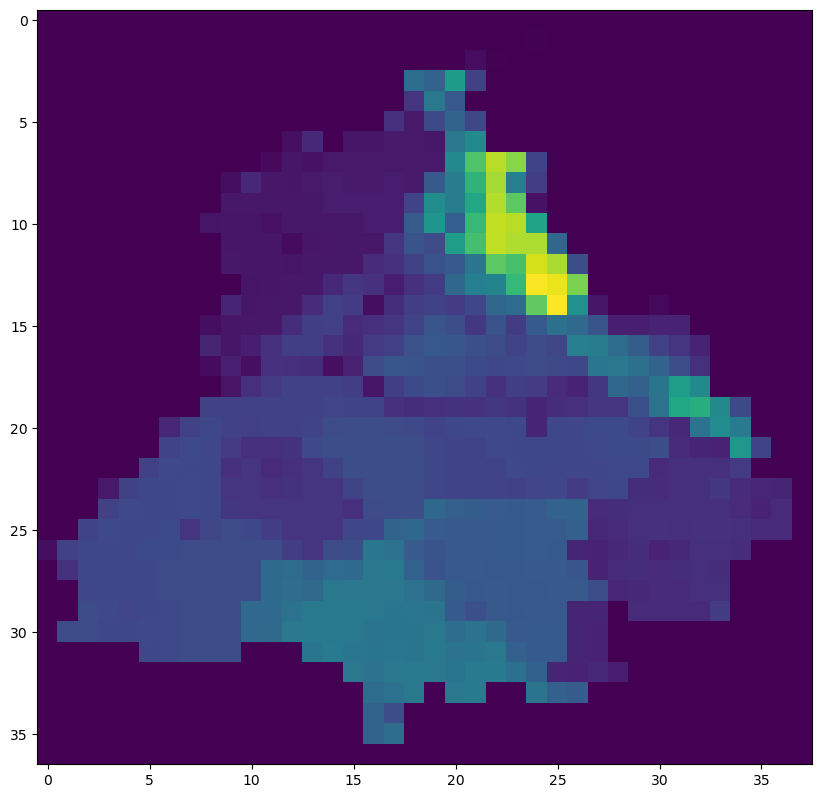

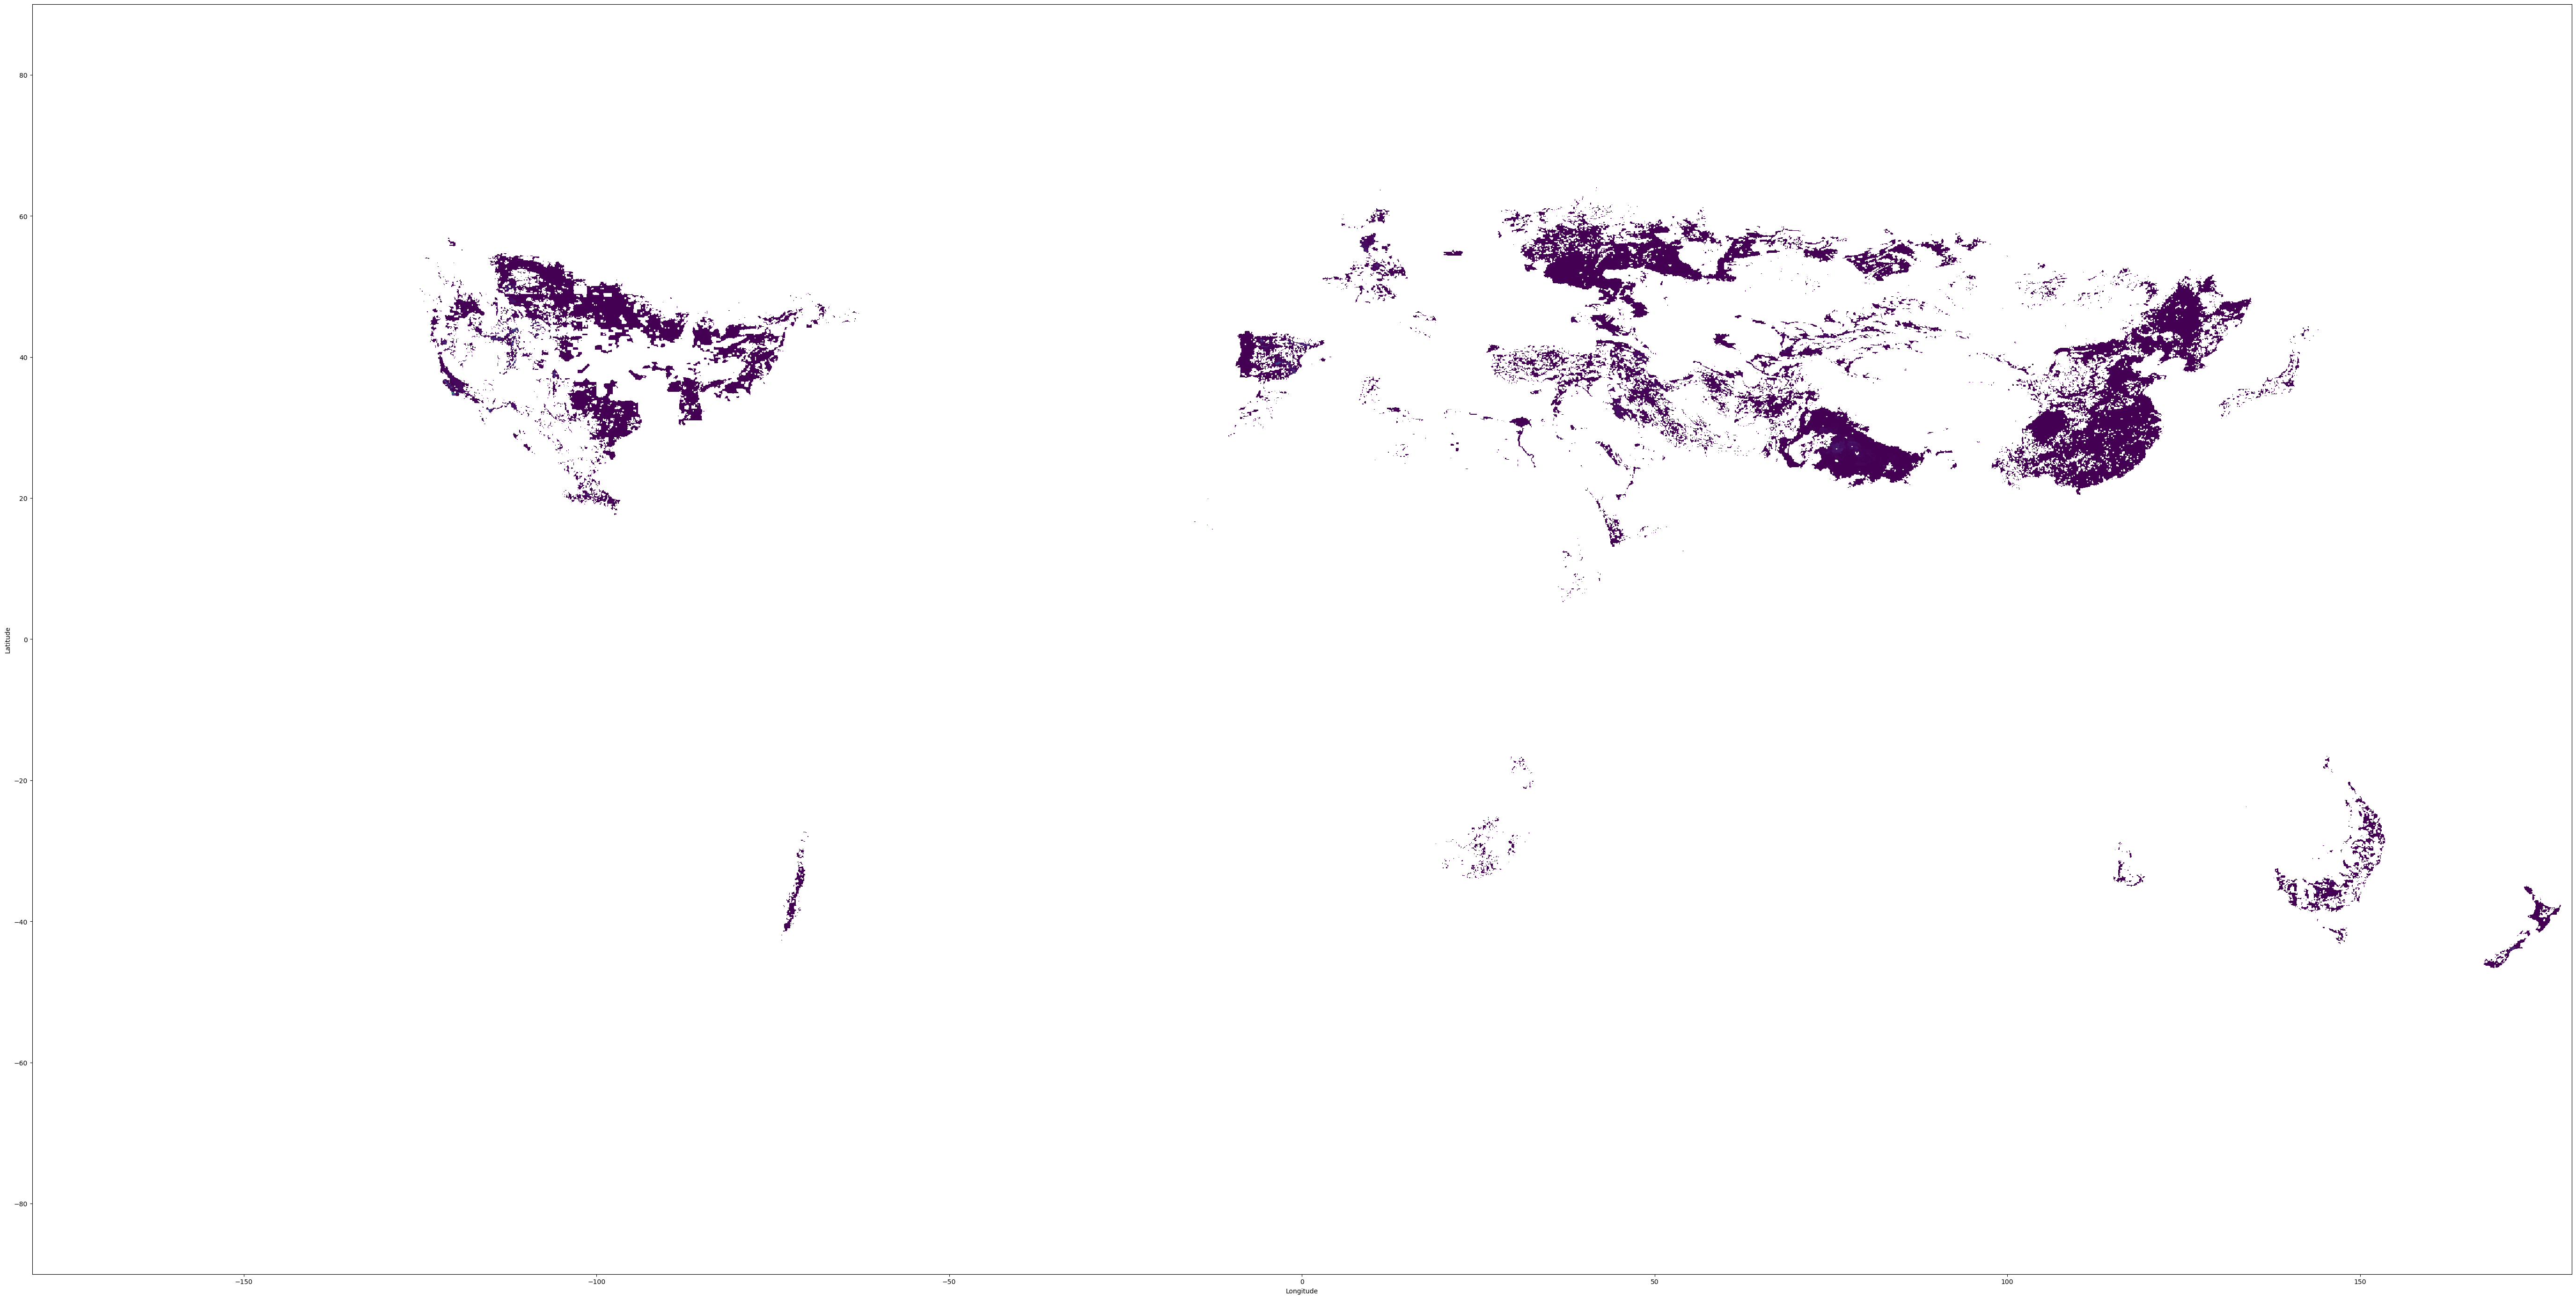

In [9]:
#Importing necessary libraries
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.crs import CRS


# Punjab shapefile already exists in the punjab variable

# Opening the barley raster
with rasterio.open(barley_raster) as src:
    
    crs= src.crs
    punjab.crs=crs
    # Clipping the raster using the Punjab shapefile and Kerala shapefile
    clipped, transform = mask(src, punjab.geometry, crop=True )
    clipped_2, transform_2 = mask(src, kerala.geometry, crop=True)
    
    # Calculating the sum of pixel values
    sum_value_1 = clipped.sum()
    sum_value_2 = clipped_2.sum()

    print("Sum of pixel values for Punjab:", sum_value_1)
    print("Sum of pixel values for Kerala:", sum_value_2)
    plt.figure(figsize=(10, 10))
    show(clipped, cmap = 'viridis')
    

    
    plt.figure(figsize=(70,70))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    show (src, cmap='viridis')
    

# The value on the axes are different from what you would generally expect for latitude and longitude values for punjab but 
# that is because we have taken here the same transform as the original raster and that assigns specific values to the edges
# of the plot. To avoid this the transofrm being used can be modified by modifying two of the values in the Affine as has 
# been done below for potential yield cases. In this case the axesa values will not affect the calculations because the shape
# extracted is correct and the pixel values in that will remain same irrespective of what is done for the x and y axes values.



Now I will demonstrate how we will proceed to calculate the biomass potential for the state of Punjab and Kerala for the year 2000 with irrigation available.

In [10]:
# Iterating over each crop in the first 28 rows of the production values DataFrame
combined_sum_punjab = 0
combined_sum_kerala = 0


# Applying a loop over the first 28 values of the excel so that each crop for year 2000 with irrigation as water supply is
# selected once
for i in range(28):
    crop = production_values.loc[i, 'Crop']

    # Retrieving crop raster path
    crop_raster_path = production_values.loc[i, 'Download URL']

    # Opening crop raster
    with rasterio.open(crop_raster_path) as src:
        crs = src.crs

        # Clipping the raster using the Punjab and Kerala shapefiles
        clipped_punjab, _ = mask(src, punjab.geometry, crop=True)
        clipped_kerala, _ = mask(src, kerala.geometry, crop=True)

        # Calculainge sum of pixel values
        sum_value_punjab = clipped_punjab.sum()
        sum_value_kerala = clipped_kerala.sum()

        # Retrieving residues for the specific crop from Residue DataFrame
        residue_rows = Residue.loc[Residue['Crop'] == crop]

        # Running a loop over rows containing the same crop but different residues.
        for _, residue_row in residue_rows.iterrows():
            LHV = residue_row['LHV (MJ/kg)']
            SAF = residue_row['SAF']
            RPR = residue_row['RPR']

            # Multiplying the sum of pixel values with LHV, SAF, and RPR values for the respective crop
            result_punjab = sum_value_punjab * LHV * SAF * RPR
            result_kerala = sum_value_kerala * LHV * SAF * RPR

            # Accumulating and storing the final results for Punjab and Kerala
            combined_sum_punjab += result_punjab
            combined_sum_kerala += result_kerala

# Printing the combined results for Punjab and Kerala
print("Combined Sum for Punjab:", combined_sum_punjab)
print("Combined Sum for Kerala:", combined_sum_kerala)


Combined Sum for Punjab: 135496.7114186671
Combined Sum for Kerala: 105612.70497950571


The above values are for the state of Punjab and Kerala and require some conversion before finalsing. The Energy Output was in MJ/Kg. The yield values were in 1000 tonnes which is 10^6 kg. The MJ when converted to Joule is also a factor a 10^6. So to get the value in Joule we will multiply each by 10^12.


In [11]:
# Making the above mentioned unit conversions to get the final answer in Joules.
combined_sum_punjab = combined_sum_punjab*(10**12) 
combined_sum_kerala = combined_sum_kerala*(10**12)

print("Biomass potential for Punjab , year 2000, irrigated land:", combined_sum_punjab , "Joules")
print("Biomass potential for Kerala, year 2000, irrigated land:", combined_sum_kerala ,  "Joules")


Biomass potential for Punjab , year 2000, irrigated land: 1.354967114186671e+17 Joules
Biomass potential for Kerala, year 2000, irrigated land: 1.0561270497950571e+17 Joules


Now we will start with creating the raster for the potential yield data 2011-2040 wherein I will take the rasters for the state of Punjab and Kerala, remove all the places where the crops cannot grow(for example: production forests, desserts, glaciers,protected land, etc.) and then overlap the remaining area with each crop's potential yield by running a loop like we did above.

The places which we will be removing along with their sources are as follows:
| DATA TYPE                             | YEAR/YEAR RANGE | SOURCE                  |
|---------------------------------------|-----------------|-------------------------|
| Water, Urban areas, Soil/Terrain, Dessert, Glacier | All required under all RCPs | GAEZ v4 |
| Rangeland/Pastureland                  | 2000 <br> 2020       | Columbia University <br> Tai-Rocha et al.|
| Rangeland/Pastureland  (marked)                | 2041-2070       | ESRI 2050               |
| Rangeland/Pastureland  (marked)| 2071-2100       | Tai-Rocha et al.            |
| Cropland (Permanent Crop and Arable Land)         | 2011-2040       | GAEZ v4                 |
| Cropland                              | 2041-2070       | Schneider et al./ESRI 2050 |
| Cropland                              | 2071-2100       | Schneider et al.        |
| Plantation and Production Forests     | 2015 <br>2022       | World Resources Institute <br> Zhenrong Du et al. |
| Protection Forests                     | 2009-2011       | GAEZ v4                 |
| Tree-covered land                      | 2009-2011       | GAEZ v4                 |
| Tree-covered land    (marked)                  | 2050            | ESRI 2050               |
| Tree-covered land                      | 2100           | Tai-Rocha et al.               |



According to the documentation and research the following lands are considered unsuitable for crop growth are:

- Continous or Discontinous permafrost
- Very Cold Thermal Zone TZ6 (Very Cold)
- M1 moisture class (Desert or Arid)
- L1 and L2 Land Classification which include Water bodies and Built Area
- S1, S2 and S5 soil classification (very steep areas, waterlogged/hydromorphic soils and others like rocks, glaciers)


I will be removing land from the AEZ 57 Classification and the following classes will be removed from the GAMD maps to give us the remaining area where crops can be grown potentially:

- Dominantly very steep terrains (AEZ 49)
- Land with severe soil/terrain limitations (AEZ 50)
- Dominantly hydromorphic soils (AEZ 52)
- Desert/Arid Climate (AEZ 53)
- Arctic/Very-Cold climate (AEZ 55)
- Dominantly built up land (AEZ 56)
- Dominantly inland water (AEZ 57)

For the land under forest cover, cropland and cropland (equipped with full irrigation) the data is available on GAEZ v4 for the year 2009-2011 and is available in the form of share of class for each pixel. So for each pixel we will consider the land as their respecitve category if 50% or more than 50% of it is used for that purpose. 

For the plantation and forest crops data the following arcgis data: https://www.arcgis.com/home/item.html?id=224e00192f6d408fa5147bbfc13b62dd looks to be perfect and can be converted using QGIS but the data size will be very very high so the combined raster will have to be hosted on zenodo.

For pastures one available source is NASA data for year 2000. Another method can be that we can remove the pixels with livestock density over a certain threshold which will indicate that that area is more used for grazing them rather than growing crops. (ESRI has rangeland data but their definition does not match our needs). 

A paper based on LUH2 project by the university of maryland available at this link: https://www.biorxiv.org/content/10.1101/2021.05.06.442941v6.full contains all crop and rangeland data for 2020 and 2100 under various SSPs but their format has multiple rasters in a single TIF file.

The ESRI 2050 I am unable to access as of now and for the Schneider et al. paper : https://www.nature.com/articles/s41597-022-01632-8. It has all the potentially cultivable land data in 30-years gap that we require till 2100 under two different RCPs in BIL format instead of TIF.

In [80]:
#Writing a function for extracting specific values of a pixel given the pixel values to be extracted in the form of a list and 
#the path to the raster from which these are being extracted.

import numpy as np
import pandas as pd
import rasterio
from rasterio import transform

# Loading the classification data into pandas dataframe
aez = pd.read_csv('./dataset/Classificationzones57.csv')

# Locating the path for the RCP 2.6 , 2011-2040 that we are considering
aez_path = aez.iloc[3, 9]

def coordinates_and_values(raster_path, pixel_values):
    """
    this function extracts longitude and latitudes of list of raster pixel values
    raster: load raster with rasterio
    pixel_values: list of pixel values 
    exception: pixel value must be found more than one time in raster else len of float error
    """
    with rasterio.open(raster_path) as src:
        df = pd.DataFrame()                         # create dataframe
        raster_band = src.read(1)                   # read raster band
        transform_coordinate_conversion = src.transform
        for i in pixel_values:                      # iterate between list of pixel values
            rows, cols = np.where(raster_band == i) # extract row and column numbers for each pixel
            coords = transform_coordinate_conversion * (cols, rows)
            rows, cols = coords[1], coords[0]

            values = np.array([i] * len(rows))      # create array containing n pixel value of n coordinates
            df_i = pd.DataFrame(zip(rows, cols, values), columns=['lon','lat', 'pixel']) # create dataframe for one pixel value
            df = pd.concat([df, df_i], ignore_index=True)
                    # append to get dataframe of lon and lat of list of pixel values
        return df

#Defining another function incase I need to use threshold somewhere instead of values of pixels.
def coordinates_and_threshold(raster_path, threshold):
    with rasterio.open(raster_path) as src:
        df = pd.DataFrame()  # create DataFrame
        raster_band = src.read(1)  # read raster band
        transform_coordinate_conversion = src.transform

        rows, cols = np.where(raster_band > threshold)  # find row and column indices for pixel values above threshold
        coords = transform_coordinate_conversion * (cols, rows)
        lon, lat = coords[0], coords[1]  # swap lon and lat based on your variable names

        values = raster_band[rows, cols]  # extract pixel values above threshold
        df = pd.DataFrame({'lat': lat, 'lon': lon, 'pixel': values})  # create DataFrame with coordinates and values

    return df

In [81]:
#converting the above found pandas datafram into a geodataframe containing geometry of the points.
#again here it is being done for the whole raster to show the implementation but below next I will show it for the clipped
#raster which is what we will be doing in all cases
import time
import geopandas as gpd
from shapely.geometry import Point

#shapefile
shapefile = punjab

start_time = time.time()

# Convert the DataFrame of coordinates to a GeoDataFrame
coordinates_df = coordinates_and_values(aez_path, [56])
geometry = [Point(lon, lat) for lon, lat in zip(coordinates_df['lon'], coordinates_df['lat'])]
coordinates_gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry)

elapsed_time = time.time() - start_time
print("Elapsed time:", elapsed_time, "seconds")


Elapsed time: 95.67347311973572 seconds


In [82]:
coordinates_gdf

,lon,lat,pixel,geometry
0,73.391667,54.733333,56,POINT (73.392 54.733)
1,73.383333,54.741667,56,POINT (73.383 54.742)
2,71.991667,102.533333,56,POINT (71.992 102.533)
3,71.983333,102.466667,56,POINT (71.983 102.467)
4,71.983333,102.475000,56,POINT (71.983 102.475)
...,...,...,...,...
651052,-54.800000,-68.308333,56,POINT (-54.800 -68.308)
651053,-54.808333,-68.341667,56,POINT (-54.808 -68.342)
651054,-54.808333,-68.333333,56,POINT (-54.808 -68.333)
651055,-54.808333,-68.325000,56,POINT (-54.808 -68.325)


In [11]:
#If we try to extract the pixels from the whole raster as shown above it will take a decent amount of computation time and
# even the future processes will take extra time so now we will try to do that for the clipped raster only.

# Loading the classification data into pandas dataframe
aez = pd.read_csv('./dataset/Classificationzones57.csv')

# Locating the path for the RCP 2.6 , 2011-2040 that we are considering
aez_path = aez.iloc[3, 9]

def maskingwithshapefile(shapefile, raster_path):
    with rasterio.open(raster_path) as src:
        crs= src.crs
        shapefile.crs=crs
        # Clipping the raster using the Punjab shapefile.
        clipped, transform = mask(src, shapefile.geometry, crop=True )
    return clipped

clipped_punjab_aez = maskingwithshapefile(punjab,aez_path)

# coordinates_and_values(clipped,[56]): This will throw error since clipped is a NumPy array so will have to convert this 
# to raster using rasterio and then use it in the function.

In [12]:
#Since the above obtained clipped was a numpy array and not a raster, we will eventually want a raster so that we can use 
#the coordinates_and_values function we defined above

import rasterio
from rasterio.transform import from_origin
from rasterio.transform import Affine

# Create a function to convert a NumPy array to an in-memory raster
def array_to_inmemory_raster_for_clipped(array, transform, crs, shapefile):
    
    if len(array.shape) == 2:
        array = array.reshape((1, array.shape[0], array.shape[1]))  # Add a singleton dimension

    _, height, width = array.shape  # Extract the height and width from the shape

    # Reshape the array to 2 dimensions
    array = array[0]  # Extract the first dimension to remove the extra dimension
    
    #Correcting the transform for correct axes value representation
    
    shapefile.geometry.iloc[0]
    xmin= shapefile.bounds.iloc[0,3]
    ymax=shapefile.bounds.iloc[0,0]
    topleft_corner=(xmin,ymax)


    a=transform.a
    b=transform.b
    d=transform.d
    e=transform.e

    transform=Affine(a, b, ymax, d, e, xmin)
# Update the transform with corrected values
    transform = Affine(transform.a, transform.b, ymax, transform.d, transform.e, xmin)
    
    # Define the raster metadata
    meta = {
        'count': 1,
        'dtype': array.dtype,
        'width': width,
        'height': height,
        'crs': crs,
        'transform': transform
    }

    # Create an in-memory raster file
    memory_file = rasterio.MemoryFile()
    with memory_file.open(driver='GTiff', **meta) as dst:
        dst.write(array, 1)

    return memory_file

# Assuming you already have the `clipped` array

# Get the transform and CRS from the source raster
with rasterio.open(aez_path) as src:
    transform_store = src.transform
    crs_store = src.crs

# Convert the NumPy array to an in-memory raster
inmemory_raster_punjab_for_clipped = array_to_inmemory_raster_for_clipped(clipped_punjab_aez, transform_store, crs_store, punjab)



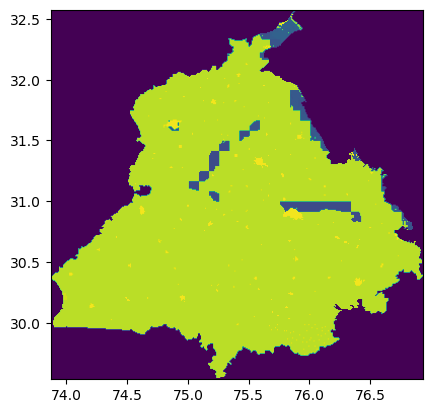

In [13]:
#This code box is just to show that now that I have updated the affine values now it represents the correct axes and hence
#the latitude and longitude values that we will store will be correct in terms of the large raster representing the globe.

with rasterio.open(inmemory_raster_punjab_for_clipped) as src2:
    show(src2)

In [14]:
clipped_coordinates_df = coordinates_and_values(inmemory_raster_punjab_for_clipped,[49,50,52,53,55,56,57])

In [14]:
# Convert the DataFrame of coordinates to a GeoDataFrame

from shapely.geometry import Point

def convert_df_to_gdf(dataframe):
    geometry = [Point(lon, lat) for lon, lat in zip(dataframe['lon'], dataframe['lat'])]
    geodf = gpd.GeoDataFrame(dataframe, geometry=geometry)
    return geodf

In [15]:
clipped_coordinates_gdf = convert_df_to_gdf(clipped_coordinates_df)
clipped_coordinates_gdf

NameError: name 'clipped_coordinates_df' is not defined

So above I was basically able to show you how we can extract certain pixels that we will want to remove and then store their coordinates in a geodataframe. These pixels and others for pastureland, plantation crops will be removed from the original clipped raster to give us the final area which we can use for growing energy crops.

In [16]:
# extracting values from pastureland.tif for pastureland data from 2000 compiled by Columbia University
pastureland_path= './dataset/pasture.tif'
# Since the affine values for pastureland are different in comparison to our GAEZ v4 data so I will be reprojecting it so as
# to convert to the appropriate pixel values and pixel size. Since we will be going to a much lower resolution so i will be 
# using cubic convolution which is the most appropriate method here since it considers a larger number of surrounding pixels
# to estimate the new pixel value.

#Cannot use QGIS and then download since the size becomes pretty high (around 35MB) and it is difficult to push such large
#files, so we will do something like MemoryFile thing we did for the clipped raster.


**Attempt to try and convert the pastureland raster to a raster where no data values are 0 and then reproject the raster**

In [17]:
#CODE FOR CONVERTING NODATA VALUES TO 0 SO THAT WE CAN REPROJECT EASILY. THIS CODE WORKS BUT NEEDED TO BE RUN ONLY ONCE.

# import rasterio
# import numpy as np

# with rasterio.open(pastureland_path) as src:
#     data = src.read(1)

# # Find the nodata pixels
# nodata_mask = data == src.nodata

# # Fill the nodata pixels with 0
# filled_data = np.where(nodata_mask, 0, data)

# # Update the metadata to reflect the nodata value
# meta = src.meta.copy()
# meta.update(nodata=0)

# # Save the filled data to a new file
# with rasterio.open("./dataset/filled_pasture.tif", "w", **meta) as dst:
#     dst.write(filled_data, 1)

In [18]:
# import rasterio
# from rasterio.warp import reproject, Resampling

GAEZ_transform=rasterio.Affine(0.008333333333333333, 0.0, -180.0, 0.0, -0.008333333333333333, 90.0)
GAEZ_crs= CRS.from_epsg(4326)

# def convert_to_correct_affine_and_pixel_values(raster_path):

#     # Define the target affine transformation matrix
#     transform_affine = rasterio.Affine(0.008333333333333333, 0.0, -180.0, 0.0, -0.008333333333333333, 90.0)

#     # Open the source raster
#     with rasterio.open(raster_path) as src:
#         # Read the source raster data
#         source_data = src.read(1)
        
#          # Get the nodata value of the source raster
#         nodata_value = src.nodata

#         # Create an empty array for the target raster data
#         target_data = np.empty((src.height, src.width), dtype=source_data.dtype)

#         # Reproject the source data to the target transformation using cubic convolution
#         reproject(
#             source_data,
#             target_data,
#             src_transform=src.transform,
#             src_crs=src.crs,
#             dst_transform=transform_affine,
#             dst_crs=src.crs,
#             resampling=Resampling.mode,
#             src_nodata=nodata_value,  # Specify the nodata value of the source raster
#             dst_nodata=nodata_value  # Preserve the nodata value in the target raster
#             )

#         return target_data
    
# converted_pastureland_array = convert_to_correct_affine_and_pixel_values(filled_pastureland_path)

In [19]:
#Create a function to convert a NumPy array to an in-memory raster for non-clipped (this won't include shapefile parameter)
def array_to_inmemory_raster_for_non_clipped(array, transform, crs):
    height, width = array.shape  # Extract the height and width from the shape

    # Define the raster metadata
    meta = {
        'count': 1,
        'dtype': array.dtype,
        'width': width,
        'height': height,
        'crs': crs,
        'transform': transform
    }

    # Create an in-memory raster file
    memory_file = rasterio.MemoryFile()
    with memory_file.open(driver='GTiff', **meta) as dst:
        dst.write(array, 1)

    return memory_file

There seems to be a problem in reprojecting using python code since it is giving blank rasters. I'll try this out later. For now to proceed with the methodology I will convert from QGIS application and then directly use the converted raster in the correct GAEZ v4 Affine matrix.


In [62]:
pastureland_converted_path = './dataset/pasture_cubic_reproject.tif'
#function for converting correct resolution pastureland to clipped and then extracting pixel values to be removed
with rasterio.open(pastureland_converted_path) as src:
    transform_pastureland = src.transform
    crs_pastureland = src.crs
    
clipped_pasture= maskingwithshapefile(iceland ,pastureland_converted_path)
 
clipped_pasture_path = array_to_inmemory_raster_for_clipped(clipped_pasture, transform_pastureland, crs_pastureland, iceland)

pasture_df = coordinates_and_threshold(clipped_pasture_path, 0.5)

clipped_pasture_gdf= convert_df_to_gdf(pasture_df)


In [63]:
clipped_pasture_gdf

,lat,lon,pixel,geometry


So the above line of code completes basically the pixel extraction scenarios and shows how we can etract pixels if we want them above a particular threshold in a region that is selected (Like above we selected Himachal Pradesh). So now from above I have shown how to do it for threshold as well as normal pixel values and have successfully extracted the pixels and their geomtries in point format with the correct latitude and longitude.

Next, I will run the crop yield values one by one , multiply them with area and respecitve LHV's and then select the max for each pixel and then sum it up. Next step would be to try and remove these pixels that I have extracted from the aez raster and the pastureland raster (not showing protected areas and cropland because here I am just trying to showcase the methodology but that can be easily done like it has been done for AEZ57 raster) from the respective shapefiles.

For the conversion uisng different methods thing since for each crop there will be different parts of crop being used for say anaerobic digestion or combustion so what we will do is try find a generalized number for the net efficiency of these processes rahter than do it individually for each crop.

In [21]:
#Creating a function which will iterate through a bunch of rasters and then give us the maximum value for each pixel.
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np


# Import the necessary library
from rasterio.io import MemoryFile

def find_max_for_each_pixel(shapefile, data_frame):
    # Initialize an array to store the maximum values
    max_values = None

    # Iterate over the global rasters
    for i in range (0, 77):
        # Open the raster file
        raster_path = data_frame.iloc[2 + 132*i, 14].strip()
        with rasterio.open(raster_path) as src:
            # Mask the raster using the Punjab boundary
            masked_data, _ = mask(src, shapefile.geometry, crop=True)

            # Check if max_values array is None (first iteration)
            if max_values is None:
                max_values = masked_data
            else:
                # Find the maximum value between the current raster and previous maximum values
                max_values = np.maximum(max_values, masked_data)

    return max_values

In [28]:
result= find_max_for_each_pixel(kerala,potential_yield)

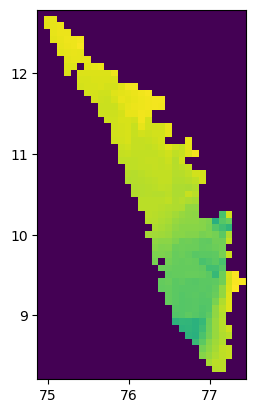

In [29]:
with rasterio.open(potential_yield.iloc[2, 14].strip()) as temp_src:
    transform_temp= temp_src.transform
    crs_temp= temp_src.crs
with rasterio.open(array_to_inmemory_raster_for_clipped(result,transform_temp, crs_temp, kerala)) as src:
    show(src)
    

Since the resolution for the actual yields and the potential yield is in resolution with pixel size 0.083333333 for both width and height. I will be converting other files from GAEZ which are in 0.0083333333333 resolution to 0.083333333333 so that the pixels idenitifed for removal are correct.

In [23]:
from rasterio.transform import Affine
from rasterio.enums import Resampling


downscale_factor = 10  # Adjust the downscale factor as needed

# initial_resolution = 0.008333333333333333
# final_resolution = 0.08333333333333333

# initial_transform = Affine(
#     initial_resolution,
#     0.0,
#     -180.0,
#     0.0,
#     -initial_resolution,
#     90.0
# )

# final_transform = Affine(
#     final_resolution,
#     0.0,
#     -180.0,
#     0.0,
#     -final_resolution,
#     90.0
# )

with rasterio.open(aez_path) as dataset:
    print(f'Before resampling, the spatial resolution is {dataset.res[0]} metres\n')

    # Compute the downsampled shape based on the downscale factor and final resolution
    downsampled_height = int(dataset.height / downscale_factor)
    downsampled_width = int(dataset.width / downscale_factor)
    downsampled_shape = (dataset.count, downsampled_height, downsampled_width)
    initial_resolution = dataset.res[0] 
    final_resolution = initial_resolution * downscale_factor

    # Resample the data to the target shape
    data = dataset.read(
        out_shape=downsampled_shape,
        resampling=Resampling.mode
    )

    # Compute the scale factors for the image transform
    scale_x =1/(initial_resolution / final_resolution)
    scale_y = 1/(-initial_resolution / -final_resolution)

    # Scale the image transform
    transform = initial_transform * initial_transform.scale(scale_x, scale_y)

show(data)


Before resampling, the spatial resolution is 0.008333333333333333 metres



NameError: name 'initial_transform' is not defined

In [ ]:
print(transform == final_resolution)

In [31]:
# desired_res_conv = "./dataset/desired_res_conv.tif" 
# with rasterio.open(desired_res_conv, 'w', driver='GTiff', height=data.shape[1], width=data.shape[2], count=data.shape[0], dtype=data.dtype, crs=dataset.crs, transform=transform) as dst:
#     dst.write(data)

Starting on with the new methodology discussed, first I will use the production values to get the share of each crop for each pixel and then store it in a pandas dataframe. Then I will use it as cropland for the future and find the agricultural residue for the future.

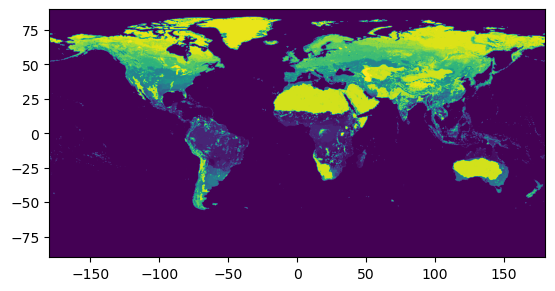

In [32]:
# Reshape the data array to have two dimensions (height x width)
reshaped_data = data[0, :, :]

# Pass the reshaped_data to the array_to_inmemory_raster_for_non_clipped function
with rasterio.open(potential_yield.iloc[2, 14].strip()) as src:
    transform_final = src.transform
    crs_final = src.crs
desired_raster_path= array_to_inmemory_raster_for_non_clipped(reshaped_data, transform_final, crs_final)
with rasterio.open(desired_raster_path) as src:
    show(src)


In [22]:
#Rather than doing for whole at once which turns out to be quite complicated let us test the method for a pair of rasters
#So I will be multiplying one production_values raster and one yield from 2040 raster using punjab shapefile.
import rasterio
from rasterio.mask import mask
import numpy

with rasterio.open(production_values.iloc[1,10]) as src:
    clipped,_= mask(src, punjab.geometry, crop=True)
with rasterio.open(potential_yield.iloc[2,14].strip()) as src:
    clipped_2,_= mask(src, punjab.geometry, crop=True)
product = numpy.multiply(clipped,clipped_2)

In [23]:
import pandas as pd
import rasterio
from rasterio.mask import mask
import numpy

merged_df = pd.merge(harvested_area, potential_yield, on='Crop', how='inner')
unique_crops = merged_df['Crop'].unique()

def future_residues(time_period, climate_model, rcp, water_supply_future, input_level, shapefile_path, water_supply_2010):
    filtered_harvested_area = harvested_area[(harvested_area['Time Period'] == 2010) &
                                             (harvested_area['Water Supply'] == water_supply_2010)]
    required_harvested_area = filtered_harvested_area[['Crop', 'Download URL']]

    filtered_potential_yield = potential_yield[(potential_yield['Time Period'] == time_period) &
                                               (potential_yield['Climate Model'] == climate_model) &
                                               (potential_yield['RCP'] == rcp) &
                                               (potential_yield['Water Supply'] == water_supply_future) &
                                               (potential_yield['Input Level'] == input_level)]
    required_potential_yields = filtered_potential_yield[['Crop', 'Download URL']]

    for crop in unique_crops:
        harvested_raster_url = required_harvested_area[required_harvested_area['Crop'] == crop]['Download URL'].values[0].strip()
        potential_yield_raster_url = required_potential_yields[required_potential_yields['Crop'] == crop]['Download URL'].values[0].strip()

        with rasterio.open(harvested_raster_url) as src:
            clipped, _ = mask(src, shapefile_path.geometry, crop=True)

        with rasterio.open(potential_yield_raster_url.strip()) as src:
            clipped_2, _ = mask(src, shapefile_path.geometry, crop=True)

        product = numpy.multiply(clipped, clipped_2)
        sum_product = numpy.sum(product)

        print(f"Crop: {crop}, Sum of Product: {sum_product}")




In [ ]:
future_residues('2041-2070', 'IPSL-CM5A-LR', 'RCP2.6','Available water content of 200 mm/m (under irrigation conditions)','High', punjab,'Irrigated')

Now for the RPR, SAF and LHV values for the crops present in potential yield, I will try to use the pre-existing data I have on most crops. For a few of the crops I will be assigning them value based on the following assumptions:
- Biomass highland sorghum, Biomass lowland sorghum, Biomass temperate sorghum, Highland sorghum, Lowland sorghum, Temperate sorghum will all be assigned just the sorghum value.
- Buckwheat will take the value of other cereals
- Onion, Cabbage, Carrot will take the value for vegetables
- Cocoa, Cocoa cumoun, Cocoa hybrid will take the value of Cocoa.
- Coffee, Coffee arabica, Coffee robusta will take the value of Coffee.
- Dryland Rice will take the value of Rice/Wetland Rice.
- Pearl millet, Foxtail millet, Millet will take the value of Millet.
- Greater yam, White yam, Yam, Yellow yam will all be assigned the value of Yam.
- Highland maize, Lowland maize, Silage maize, Temperate maize and Maize will be assigned the value of Maize.
- Spring barley, Winter barley will take the value of Barley 
- Spring rye, Winter rye will take the value of rye
- Spring wheat, Winter wheat will take the value of wheat
- White potato will take the value of Potato
- Tea will take the value of stimulants.
- ChickPea, Cowpea, Dry Pea, Pasture Legumes, Phaseolus bean, Pigeonpea will take the value of pulses.
- Alfalfa, Grass, Napier grass, Para, Rubber, Reed canary grass will take the value of fodder crops.(Alfalfa takes green fodder values which will have different RPR(0.25) but SAF will be 0.)
- SAF of jatropha has been assumed as 0.80 due to similarity to other crops like sugarcane and oil palm.

Found on the net : 
- Coconut : Reference: https://www.researchgate.net/figure/tbl7_223062794
- Citrus :  Reference: https://www.researchgate.net/figure/The-ratio-of-product-to-residue-availability-and-heating-values-of-a-selection-of_tbl1_342000532
- Jatropha : Reference : doi: 10.1016/j.rser.2015.10.009.
- Miscanthus RPR/SAF && LHV: https://www.sciencedirect.com/science/article/pii/S1161030101001022. && https://www.researchgate.net/publication/338950136_Calorific_values_of_Miscanthus_x_giganteus_biomass_cultivated_under_suboptimal_conditions_in_marginal_soils            
- Para Rubber : https://www.mdpi.com/2079-9276/9/9/114

         
                   
                   


In [66]:
#The following code is for removing/masking the extracted pixel corodinates we have obtained from various places like say 
#deserts, glaciers etc.

import numpy as np

with rasterio.open(potential_yield.iloc[2,14].strip()) as src:
    clipped, transform = mask(src, iceland.geometry, crop= 'True')
    crs=src.crs

raster_used= array_to_inmemory_raster_for_clipped(clipped, transform , crs, iceland)


dataset = rasterio.open(raster_used)

# Load the GeoDataFrame
gdf = clipped_pasture_gdf

# Convert the geometry column to pixel coordinates
pixel_coords = []
for geometry in gdf['geometry']:
    lon, lat = geometry.x, geometry.y
    x, y = dataset.index(lon, lat)
    pixel_coords.append((x, y))

# Create a mask with the same dimensions as the raster
masked = np.zeros((dataset.height, dataset.width), dtype=np.uint8)

# Set the pixels at the specified coordinates to a nodata value
nodata_value = 255
for x, y in pixel_coords:
    masked[x, y] = nodata_value

# Read the raster data
data = dataset.read(1)

# Apply the mask
data = np.where(masked == nodata_value, np.nan, data)

# Continue working with the data variable, which now contains the masked raster data as an array

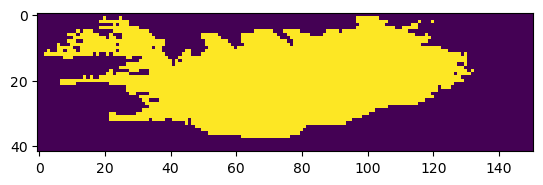

<Axes: >

In [65]:
show(data)

In [25]:
import numpy as np
import rasterio
from rasterio.mask import mask

def remove_pixels(raster_path, shapefile, geodataframe):
    with rasterio.open(raster_path) as src:
        # Mask the raster using the shapefile boundary
        clipped, transform = mask(src, shapefile.geometry, crop=True)
        crs = src.crs

    raster_used = array_to_inmemory_raster_for_clipped(clipped, transform, crs, shapefile)

    dataset = rasterio.open(raster_used)
    
    # Load the GeoDataFrame
    gdf = geodataframe
    
    # Convert the geometry column to pixel coordinates
    pixel_coords = []
    for geometry in gdf['geometry']:
        lon, lat = geometry.x, geometry.y
        x, y = dataset.index(lon, lat)
        pixel_coords.append((x, y))
    
    # Create a mask with the same dimensions as the raster
    masked = np.zeros((dataset.height, dataset.width), dtype=np.uint8)
    
    # Set the pixels at the specified coordinates to a nodata value
    nodata_value = 255
    for x, y in pixel_coords:
        masked[x, y] = nodata_value
    
    # Read the raster data
    data = dataset.read(1)
    
    # Apply the mask
    data = np.where(masked == nodata_value, np.nan, data)
    
    return data


def find_max_for_each_pixel_2(shapefile, data_frame , geodataframe):
    # Initialize an array to store the maximum values
    max_values = None
    
    # Iterate over the global rasters
    for i in range(0, 77):
        # Open the raster file
        raster_path = data_frame.iloc[2 + 132 * i, 14].strip()
        
        # Remove pixels from the raster
        data = remove_pixels(raster_path, shapefile , geodataframe)
        
        # Check if max_values array is None (first iteration)
        if max_values is None:
            max_values = data
        else:
            # Find the maximum value between the current raster and previous maximum values
            max_values = np.maximum(max_values, data)
    
    return max_values



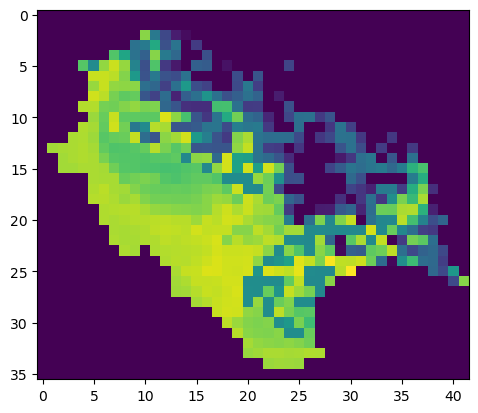

<Axes: >

In [26]:
show(find_max_for_each_pixel_2(himachal_pradesh, potential_yield, clipped_pasture_gdf))

In [36]:
import rasterio
from rasterio.mask import mask
import numpy as np

def get_net_harvested_area(shapefile, time_period, water_supply , geodataframe):
    
    net_harvested_area_obtained = None  # Initialize the net harvested area array
    
    filtered_harvested_area = harvested_area[(harvested_area['Time Period'] == time_period) &
                                                   (harvested_area['Water Supply'] == water_supply)]
    required_harvested_area = filtered_harvested_area['Download URL']
    
    for required_url in required_harvested_area:
        required_url = required_url.strip()
        
        with rasterio.open(required_url) as src:
            # Assuming shapefile is used for clipping
            # Adjust accordingly if using a different method for clipping
            
            # Clip the raster using the shapefile
            data = remove_pixels(required_url, shapefile , geodataframe)
            
            # Get the harvested area values from the clipped data
            harvested_area_obtained = data  # Adjust this line if necessary
            
            # Update the net harvested area array
            if net_harvested_area_obtained is None:
                net_harvested_area_obtained = harvested_area_obtained
            else:
                net_harvested_area_obtained += harvested_area_obtained
    
    return net_harvested_area_obtained*(1000)


In [37]:
harvest_himachal = get_net_harvested_area(himachal_pradesh , 2010 , 'Total', clipped_pasture_gdf)

In [38]:
np.nansum(harvest_himachal)

1266671.1

In [30]:
#Next to generate a numpy array with total area of pixel.
with rasterio.open(potential_yield.iloc[2,14].strip())as src:
    transform = src.transform
    crs = src.crs
transform


Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)

In [68]:
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import geopandas as gpd
# import numpy as np
# from rasterio.mask import mask
# from rasterio.windows import from_bounds

# # Read the raster and shapefile
# raster_path = "https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/CRUTS32/Hist/6190H/barl200a_yld.tif"
# raster = rasterio.open(raster_path)
# shapefile = rajasthan

# crs_initial = raster.crs
# transform_intial = raster.transform

# # Clip the raster to the extent of the shapefile
# clipped_array, transform_initial = mask(dataset=raster, shapes=shapefile.geometry, crop=True)
# clipped_raster = array_to_inmemory_raster_for_clipped(clipped_array, transform_intial , crs_initial , punjab )

# # Determine the appropriate UTM zone based on the shapefile's centroid
# centroid = shapefile.to_crs('EPSG:4326').centroid.squeeze()
# longitude, latitude = centroid.x, centroid.y
# utm_zone = int((longitude + 180) / 6) + 1
# hemisphere = 'N' if latitude >= 0 else 'S'
# utm_epsg_code = f'326{utm_zone:02d}' if hemisphere == 'N' else f'327{utm_zone:02d}'
# target_crs = f'EPSG:{utm_epsg_code}'

# # Load the source raster
# with rasterio.open(clipped_raster) as src:
#     # Define the target CRS
#     target_crs = rasterio.crs.CRS.from_string(target_crs)
#     check = src.read()
#     meta_src = src.meta

#     # Calculate the transformation parameters
#     transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)

#     # Create a destination array for the reprojected raster
#     destination = MemoryFile().open(driver='GTiff', width=width, height=height, count=src.count,
#                                     dtype=src.dtypes[0], crs=target_crs, transform=transform)

#     # Perform the reprojection
#     reproject(source=rasterio.band(src, 1), destination=rasterio.band(destination, 1),
#               src_transform=src.transform, src_crs=src.crs,
#               dst_transform=transform, dst_crs=target_crs, src_nodata=-9, dst_nodata=-9,
#               resampling=Resampling.nearest)
#     reprojected_raster = destination.read(1)  # Read the reprojected data
#     reprojected_raster_metadata = destination.meta  # Get the metadata of the reprojected raster
   

# # Calculate the pixel size in the target CRS
# pixel_size_x = abs(transform[0])
# pixel_size_y = abs(transform[4])

# # Calculate the area per pixel in square kilometers
# pixel_area_km2 = pixel_size_x * pixel_size_y / 1000000  # Convert square meters to square kilometers

# reprojected_raster_modified = np.where((reprojected_raster != -9),
#                                        pixel_area_km2,
#                                        reprojected_raster)
# # Set -9 values to zero
# reprojected_raster_modified_no_minus_9 = np.where(reprojected_raster_modified == -9, 0, reprojected_raster_modified)




##NEEDED ONLY TILL ABOVE

# # Reproject the clipped raster to the target CRS
# with clipped_raster.open() as src:
#     transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': target_crs,
#         'transform': transform,
#         'width': width,
#         'height': height
#     })

#     # Create the output file path
#     output_path = './dataset/conv_test_3.tif'
    
#     # Reproject and save the raster to disk
#     with rasterio.open(output_path, 'w', **kwargs) as dst:
#         for i in range(1, src.count + 1):
#             reproject(
#                 source=rasterio.band(src, i),
#                 destination=rasterio.band(dst, i),
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=target_crs,
#                 resampling=Resampling.nearest
#             )

So the code above clearly works correctly and gives us the correct area estimation for a lot of states, including Rajasthan, Mizoram, Kerala, Punjab. The code above at the same time also causes a few problems for us, since the shapefile is in a different crs and so is the raster, now we will have to make similar changes in all of the previous code. But more importantly the major restriction is that it will only be accurate for say about 6 degrees of longitude and beyond that the results will start to get troublesome. This will not hold at all if we want to calculate values for say a lareg country like Russia or US.

In [34]:
#To check if an approximation without changing the crs would be a better way out I am writing the following code.

from math import atan2, pi, radians, sin, cos, sqrt
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping


def haversine_area(lon, lat):
    # Earth's radius in kilometers
    R = 6371.0
    
    # Convert lat/lon to radians
    lat_rad = radians(lat)
    lon_rad = radians(lon)
    
    # Haversine formula to calculate the area
    a = sin(lat_rad / 2) ** 2 + cos(lat_rad) * sin(lon_rad / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    area = R ** 2 * c
    
    return area

def degree_to_meter_conversion_factor(latitude):
    # Earth's radius in meters
    R = 6371000.0
    
    # Conversion factor from degrees to meters at a given latitude
    conversion_factor = (2 * pi * R * cos(radians(latitude.iloc[0]))) / 360.0
    
    return conversion_factor

In [52]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np


# Read the raster data
raster_path = potential_yield.iloc[2,14].strip()
with rasterio.open(raster_path) as src:
    # Clip the raster using the shapefile boundaries
    clipped_data, clipped_transform = mask(src, iceland.geometry, crop=True)

# Get the pixel dimensions of the clipped raster
pixel_width = clipped_transform[0]
pixel_height = clipped_transform[4]

# Calculate the area of each pixel based on latitude
pixel_area = np.zeros_like(clipped_data, dtype=np.float32)

for band in range(clipped_data.shape[0]):
    for row in range(clipped_data.shape[1]):
        for col in range(clipped_data.shape[2]):
            if clipped_data[band, row, col] != src.nodata:
                lat = rasterio.transform.xy(clipped_transform, row, col, offset='center')[1]
                lat_rad = np.radians(lat)
                pixel_area[band, row, col] = np.abs(pixel_width * pixel_height * (111319.9)**2)*(np.cos(lat_rad))/(10**6)

In [54]:
np.sum(pixel_area)

101541.67

In [55]:
pixel_area[0][2]

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   , 34.487, 34.487, 34.487, 34.487, 34.487,
       34.487, 34.487, 34.487, 34.487,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   , 34.487, 34.487, 34.487, 34.487, 34.487, 34.487, 34.487,
       34.487, 34.487, 34.487,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

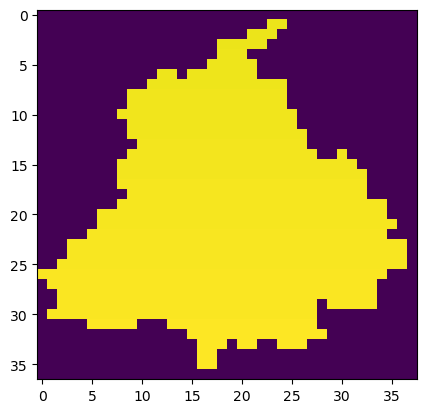

<Axes: >

In [40]:
show(pixel_area)

In [41]:
array_sub = np.subtract(pixel_area, harvest_himachal)

In [42]:
np.sum(array_sub)

4291476.5

In [47]:
iceland.geometry

0    MULTIPOLYGON (((-20.32448 63.38907, -20.32292 ...
Name: geometry, dtype: geometry